# Regressione lineare
In questo notebook eseguiremo una regressione lineare multipla utilizzando il Boston Housing Dataset.
14 features:

**CRIM** Tasso di criminalità per capita<br>
**ZN** Percentuale di terreni residenziali suddivisi in zone per lotti superiori a 25.000 sq.ft.<br>
**INDUS** Percentuale di ettari di attività non al dettaglio per città.<br>
**CHAS** Variabile dummy che indica la prossimità al fiume Charles.<br>
**NOX** Concentrazione di ossido d'azoto (parti per 10 milioni).<br>
**RM** Numero medio di stanze per abitazione<br>
**AGE** Percentuale di abitazione occupate costruite dopo il 1940<br>
**DIS** Media pesata delle distanze da 5 centri lavorativi di Boston.<br>
**RAD** Indice di accessibilità ad autostrade<br>
**TAX** Aliquota dell'imposta sulla proprietà a valore pieno in 10.000 USD.<br>
**PRATIO** Rapporto studente-insegnante per città.<br>
**BLACK** 1000(Bk - 0.63)^2 dove Bk è la percentuale di abitanti di colore per città<br>
**LSTAT** Percentuale della popolazione povera<br>
**MEDV** Mediana del valore di abitazioni occupate in 1.000 USD.<br>

Il nostro obiettivo è predirre il **MEDV**.<br>

Utilizziamo la predizione del modello per calcolare l'errore utilizzando l'errore quadratico medio (MSE - Mean Squared Error).<br>
Esso consiste nella media della somma degli errori al quadrato.
$$MSE = \frac{1}{N}\sum_{i=1}^{N}(Y_i-\hat{Y}_i)^2$$
dove $\hat{Y}$ corrisponde alla predizione del modello.<br>
**NOTA BENE** L'MSE corrisponde alla somma dei quadrati residui (RSS - Residual Sum of Squares) di cui viene calcolato il valore medio.

Introduciamo un ulteriore metrica per valutare il nostro modello: **il coefficente di determinazione (R^2)**.<br>
$$ R^2 = 1-\frac{RSS}{SST}$$
dove $RSS$ è la somma dei quadrati residui:
$$RSS = \sum_{i=1}^{N}(Y_i-\hat{Y}_i)^2$$
ed SST è la somma dei quadrati totali:
$$SST = \sum_{i=1}^{N}(Y_i-Y_{mean})^2$$
<br>
in pratica R^2 è una versione standardizzata del MSE che torna un punteggio compreso tra 0 e 1 per il train set, mentre per il test set può assumere anche valori negativi.
**NOTA BENE** R^2 non è una funzione di costo, ma di punteggio, un valore di 1 vuol dire che la predizione del modello è sempre corretta ( cosa improbabile in casi reali ). Quindi tanto più vicino ad 1 è l'R2 tanto migliore è il modello.
    
* **R2_score < 0.3** il modello è inutile.
* **0.3 < R2_score < 0.5** il modello è scarso.     
* **0.5 < R2_score < 0.7** il modello è discreto.
* **0.7 < R2_score < 0.9** il modello è buono.
* **0.9 < R2_score < 1** il modello è ottimo.
* **R2_score = 1** molto probabilmente c'è un errore nel modello.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Carichiamo il dataset dalla repository in un DataFrame

In [2]:
boston = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data", sep='\s+', 
                     names=["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PRATIO","B","LSTAT","MEDV"])
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Regressione lineare multipla su un subset delle features

Cominciamo esplorando il DataFrame alla ricerca di correlazioni tra le varie features e tra le features e il target MEDV.<br>
In questi casi è molto utile il metodo *corr* del DataFrame, che ritorna un indice della correlazione tra le varie colonne. L'indice è un valore in un range tra -1 e 1 che assume questi significati:
* **Valore tendente allo 0:** La correlazione tra le features è nulla o scarsa.
* **Valore tendente ad 1:** Le features sono direttamente correlate (l'aumento della prima comporta l'aumento della seconda)
* **Valore tendente ad -1:** Le features sono inversamente correlate (l'aumento della prima comporta il decremento della seconda)

In [3]:
boston.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


Ecco i nostro indici di correlazione, ma tutti questi numeri creano molto confusione, esiste un modo migliore per visualizzare le correlazioni ? Certo, una **heatmap**.<br>
Una heatmap rappresenta le correlazioni tramite colori.
Per creare la heatmap delle correlazioni possiamo utilizzare seaborn, una libreria python che si appoggia ad matplotlib per creare grafici e visualizzazioni eleganti in poche righe di codice.

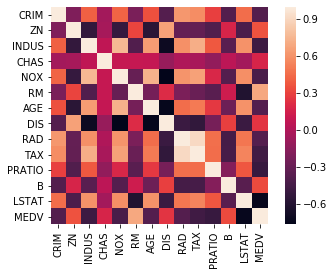

In [4]:
import seaborn as sns

#sns.set(font_scale=1.5)
hm = sns.heatmap(boston.corr(),
                 cbar=True, #disegna una barra con l'intensità del colore
                 square=True, #forza le caselle a una dimensione quadrata
                 yticklabels=boston.columns, #labels per i valori sull'asse Y
                 xticklabels=boston.columns) #labels per i valori sull'asse X
plt.show()

Ecco la nostra heatmap, la barra verticale sulla destra indica lo spettro della correlazione:
* Tendente al rosso vuol dire nessuna o scarsa correlazione (valore 0)
* Tendente al nero vuol dire correlazione inversa (valore -1)
* Tendente al bianco vuol dire correlazione diretta (valore 1). 

Ovviamente la diagonale tende al bianco perchè rappresenta la correlazione tra una feature e se stessa.<br>
Le features più direttamente correlate con MEDV sembrerebbero essere RM e ZN, mentre quelle più inversamente correlate LSTAT, PRATIO, TAX e INDUS.<br><br>
Creiamo un'altra heatmap più piccola contenente solo queste features e questa volta stampiamo anche il valore numerico della correlazione

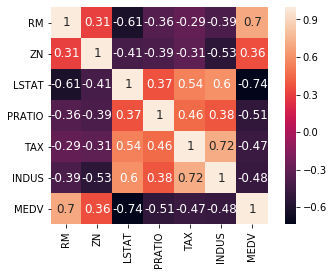

In [5]:
import seaborn as sns

cols=['RM',"ZN","LSTAT","PRATIO","TAX","INDUS","MEDV"]

hm = sns.heatmap(boston[cols].corr(),
                 cbar=True,
                 square=True,
                 yticklabels=boston[cols].columns,
                 xticklabels=boston[cols].columns,
                 annot=True,                          #Questo ci mostra i valori degli indici
                 annot_kws={'size':12})               #Impostiamo la dimensione dell'annotazione a 12 per farla entrare dentro il quadrato

plt.show()

Usiamo sempre seaborn per visualizzare le correlazioni su di un grafico.

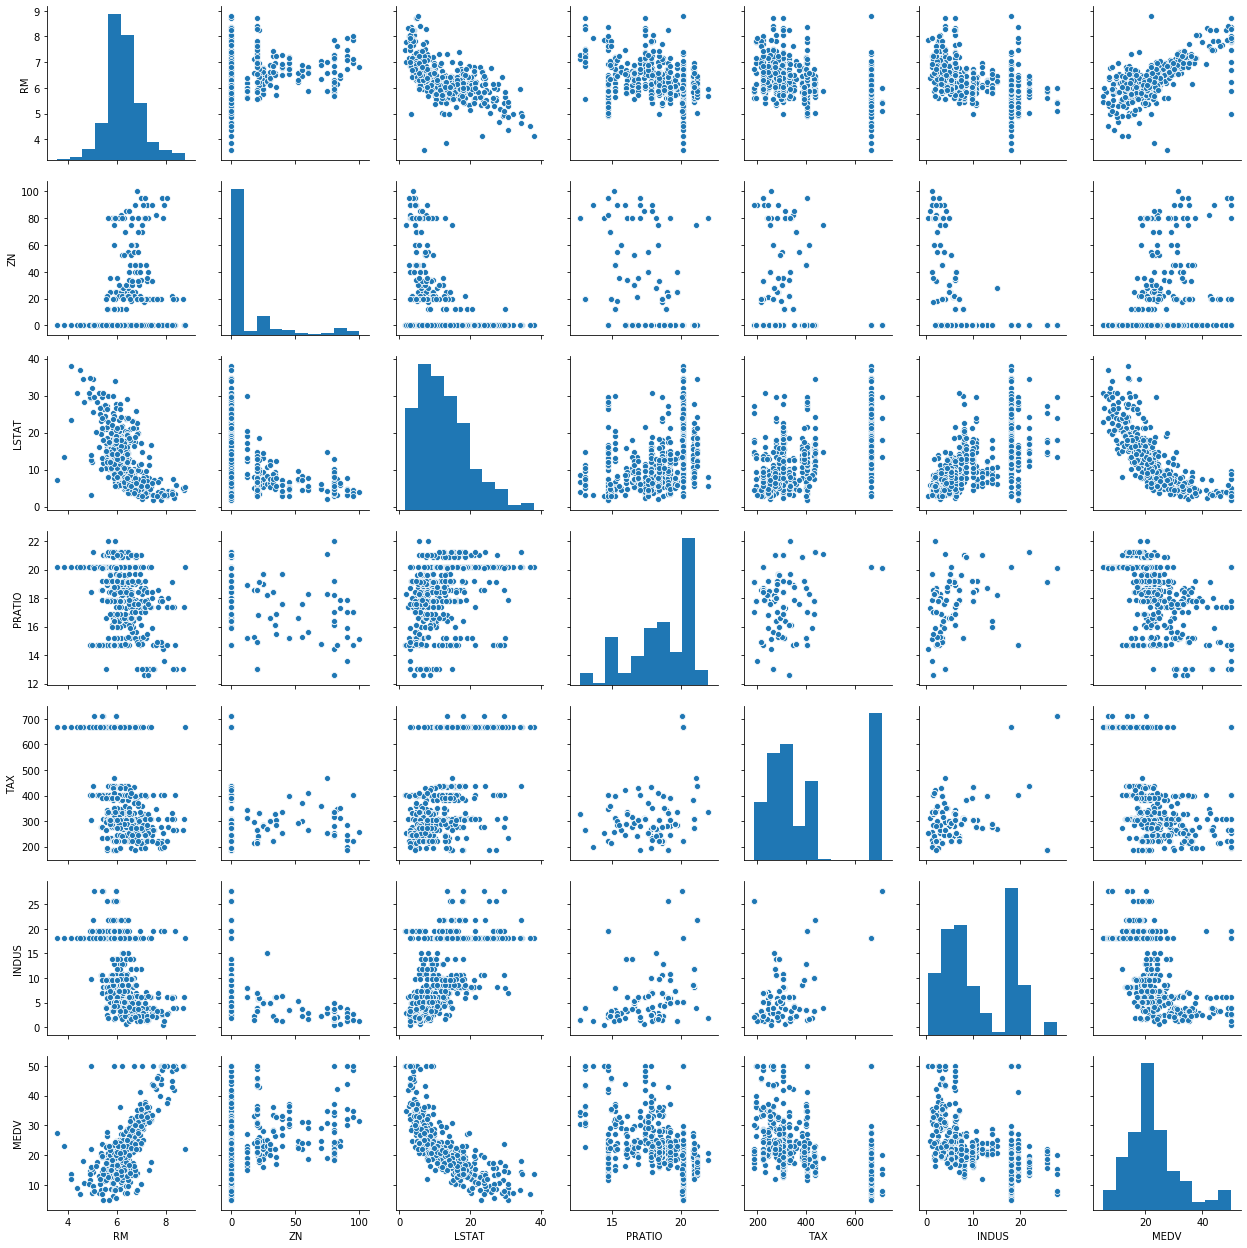

In [6]:
sns.pairplot(boston[cols])

Come avevamo notato, la correlazione tra RM, LSTAT ed MEDV è piuttosto forte, bene, proviamo a costruire un modello di regressione lineare multipla utilizzando queste due features.

In [7]:
X = boston[["RM","LSTAT"]].values
Y = boston["MEDV"].values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))

MSE: 32.72507169281496
R2 score: 0.6069792285352371


Errore è punteggio ottenuti in questo modo sono migliori rispetto a quanto è possibile ottenere effettuando la regressione su una sola delle due features.

## Regressione lineare multipla su tutte le features
Adesso eseguiamo una regressione lineare multipla su tutte le features

In [8]:
from sklearn.preprocessing import StandardScaler

X = boston.drop("MEDV", axis=1).values
Y = boston["MEDV"].values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=0)

Questa volta standardizziamo il dataset

In [9]:
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

Ed eseguiamo la regressione

In [10]:
ll = LinearRegression()
ll.fit(X_train_std, Y_train)
Y_pred = ll.predict(X_test_std)

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))

MSE: 27.195965766883205
R2 score: 0.6733825506400195


Errore e punteggio ottenuti in questo modo sono decisamente migliori, vediamo quali proprietà hanno più peso nella regressione osservandone i coefficenti.

In [11]:
weights = pd.DataFrame(data=list(zip(boston.columns, ll.coef_)), columns=['feature', 'weight'])
weights

,feature,weight
0,CRIM,-1.011901
1,ZN,1.050280
2,INDUS,0.079210
3,CHAS,0.618962
4,NOX,-1.873691
5,RM,2.705270
6,AGE,-0.279573
7,DIS,-3.097665
8,RAD,2.096900
9,TAX,-1.886063
